# Tweet classification: Trump vs. Trudeau

<p>In this notebook, we'll be investigating how to properly classify tweets from two prominent North American politicians: Donald Trump and Justin Trudeau.</p>
<p><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/47/President_Donald_Trump_and_Prime_Minister_Justin_Trudeau_Joint_Press_Conference%2C_February_13%2C_2017.jpg/800px-President_Donald_Trump_and_Prime_Minister_Justin_Trudeau_Joint_Press_Conference%2C_February_13%2C_2017.jpg" alt="Donald Trump and Justin Trudeau shaking hands." height="50%" width="50%"></p>
<p><a href="https://commons.wikimedia.org/wiki/File:President_Donald_Trump_and_Prime_Minister_Justin_Trudeau_Joint_Press_Conference,_February_13,_2017.jpg">Photo Credit: Executive Office of the President of the United States</a></p>
<p>Tweets pose specific problems to NLP, including the fact they are shorter texts. There are also plenty of platform-specific conventions to give you hassles: mentions, #hashtags, emoji, links and short-hand phrases (ikr?).</p>
<p>To begin, we will import all the tools we need from scikit-learn. We will need to properly vectorize our data (<code>CountVectorizer</code> and <code>TfidfVectorizer</code>). And we will also want to import some models, including <code>MultinomialNB</code> from the <code>naive_bayes</code> module, <code>LinearSVC</code> from the <code>svm</code> module and <code>PassiveAggressiveClassifier</code> from the <code>linear_model</code> module. Finally, we'll need <code>sklearn.metrics</code> and <code>test_train_split</code> and <code>GridSearchCV</code> from the <code>model_selection</code> module to evaluate and optimize our model.</p>

In [1]:
# Import necessary modules

import pandas as pd

%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn import metrics

import random; random.seed(53) # Set seed for reproducibility

## Transforming our collected data
<p>To begin, let's start with a corpus of tweets which were collected in November 2017. They are available in CSV format. We'll use a Pandas DataFrame to help import the data and pass it to scikit-learn for further processing.</p>
<p>Since the data has been collected via the Twitter API and not split into test and training sets, we'll need to do this. Let's use <code>test_train_split()</code> with <code>random_state=53</code> and a test size of 0.33, just as we did in the DataCamp course. This will ensure we have enough test data and we'll get the same results no matter where or when we run this code.</p>

In [2]:
# Load data
tweet_df = pd.read_csv('data/tweets.csv')

tweet_df.sample(5)

,id,author,status
320,321,Justin Trudeau,Happy 150th birthday to Marie Curie! Learn mor...
240,241,Justin Trudeau,RT @DefenseCanada: L’importance du Souvenir #L...
356,357,Justin Trudeau,Le Canada offre sa solidarité à ses voisins fa...
303,304,Justin Trudeau,Visit to Ho Chi Minh’s stilt house near the Pr...
369,370,Justin Trudeau,"Today, we join Sikhs in Canada &amp; around th..."


In [3]:
tweet_df.shape

(400, 3)

In [4]:
tweet_df.author.value_counts()

Donald J. Trump    200
Justin Trudeau     200
Name: author, dtype: int64

In [5]:
# Create features and target
X = tweet_df['status']
y = tweet_df['author']

# Split training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=53) # test_size=0.25, random_state=53

## Vectorize the tweets
<p>We have the training and testing data all set up, but we need to create vectorized representations of the tweets in order to apply machine learning. To do so, we will utilize the <code>CountVectorizer</code> and <code>TfidfVectorizer</code> classes which we will first need to fit to the data. Once this is complete, we can start modeling with the new vectorized tweets!</p>

`CountVectorizer` converts a collection of text documents to a matrix of token counts. It implements both tokenization and occurrence counting in a single class. `TfidfVectorizer` converts a collection of raw documents to a matrix of TF-IDF features. 
> The goal of using [tf-idf](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer) instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

In [6]:
"""
When building the vocabulary, ignore terms that have a document frequency
strictly higher/lower than the given threshold (corpus-specific stop words) 
>> In this example: ignore terms with frequency higher than 0.9 and lower than 0.05
"""

# Initialize count vectorizer
count_vectorizer = CountVectorizer(stop_words='english', max_df=0.9, min_df=0.05)

# Create count train and test variables
count_train = count_vectorizer.fit_transform(X_train) #Learn the vocabulary dictionary and return term-document matrix.
count_test = count_vectorizer.transform(X_test) # Transform documents to document-term matrix.

In [7]:
count_train

<268x16 sparse matrix of type '<class 'numpy.int64'>'
	with 508 stored elements in Compressed Sparse Row format>

In [8]:
count_train.toarray()

array([[0, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]])

In [9]:
print(count_vectorizer.get_feature_names()) # Array mapping from feature integer indices to feature name

['amp', 'canada', 'du', 'et', 'great', 'https', 'la', 'le', 'les', 'nous', 'pour', 'president', 'rt', 'thank', 'today', 'vietnam']


In [10]:
# Initialize tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.9, min_df=0.05)

# Create tfidf train and test variables
tfidf_train = tfidf_vectorizer.fit_transform(X_train) # Learn vocabulary and idf, return term-document matrix.
tfidf_test = tfidf_vectorizer.transform(X_test) # Transform documents to document-term matrix.

In [11]:
print(tfidf_vectorizer.get_feature_names()) # rray mapping from feature integer indices to feature name

['amp', 'canada', 'du', 'et', 'great', 'https', 'la', 'le', 'les', 'nous', 'pour', 'president', 'rt', 'thank', 'today', 'vietnam']


## Training a multinomial naive Bayes model

Now that we have the data in vectorized form, we can train the first model. `sklearn.naive_bayes.MultinomialNB` is a Naive Bayes classifier for multinomial models. 
> The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work. [ref](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)

Let's investigate using the Multinomial Naive Bayes model with both the <code>CountVectorizer</code> and <code>TfidfVectorizer</code> data. Accuracy scores for both models suggest that `TfidfVectorizer` performs better. 

In [12]:
# Create a MulitnomialNB model
count_nb = MultinomialNB()

count_nb.fit(count_train, y_train)

# Run predict on count test data to get predictions
count_nb_pred = count_nb.predict(count_test)

# Calculate the accuracy of predictions
count_nb_score = count_nb.score(count_test, y_test)

print('NaiveBayes Count Score: ', count_nb_score)

NaiveBayes Count Score:  0.7954545454545454


In [13]:
pd.DataFrame([count_nb_pred[:5], y_test[:5]], index=['pred', 'test']).T

,pred,test
0,Donald J. Trump,Donald J. Trump
1,Donald J. Trump,Donald J. Trump
2,Donald J. Trump,Donald J. Trump
3,Justin Trudeau,Donald J. Trump
4,Justin Trudeau,Justin Trudeau


In [14]:
# Create a MulitnomialNB model
tfidf_nb = MultinomialNB()

tfidf_nb.fit(tfidf_train, y_train)

# Run predict on TF-IDF test data to get predictions
tfidf_nb_pred = tfidf_nb.predict(tfidf_test)

# Calculate the accuracy of predictions
tfidf_nb_score = tfidf_nb.score(tfidf_test, y_test)

print('NaiveBayes Tfidf Score: ', tfidf_nb_score)

NaiveBayes Tfidf Score:  0.803030303030303


In [15]:
pd.DataFrame([tfidf_nb_pred[:5], y_test[:5]], index=['pred', 'test']).T

,pred,test
0,Donald J. Trump,Donald J. Trump
1,Donald J. Trump,Donald J. Trump
2,Donald J. Trump,Donald J. Trump
3,Justin Trudeau,Donald J. Trump
4,Justin Trudeau,Justin Trudeau


## Evaluating our model using a confusion matrix
<p>We see that the TF-IDF model performs better than the count-based approach. Based on what we know from the NLP fundamentals course, why might that be? We know that TF-IDF allows unique tokens to have a greater weight - perhaps tweeters are using specific important words that identify them! Let's continue the investigation.</p>
<p>For classification tasks, an accuracy score doesn't tell the whole picture. A better evaluation can be made if we look at the confusion matrix, which shows the number of correct and incorrect classifications based on each class. We can use the metrics, True Positives, False Positives, False Negatives, and True Negatives, to determine how well the model performed on a given class. How many times was Trump misclassified as Trudeau?</p>

In [16]:
# Calculate the confusion matrices for the tfidf_nb model and count_nb models
count_nb_cm = metrics.confusion_matrix(y_test, count_nb_pred, labels=['Donald J. Trump', 'Justin Trudeau'])
tfidf_nb_cm = metrics.confusion_matrix(y_test, tfidf_nb_pred, labels=['Donald J. Trump', 'Justin Trudeau'])

print(count_nb_cm)

print(tfidf_nb_cm)

[[56  2]
 [25 49]]
[[56  2]
 [24 50]]


Confusion matrix, without normalization
Confusion matrix, without normalization


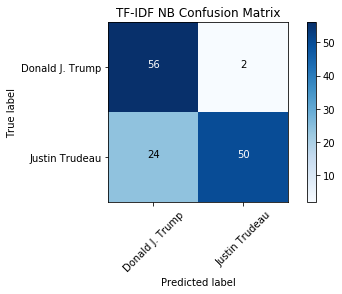

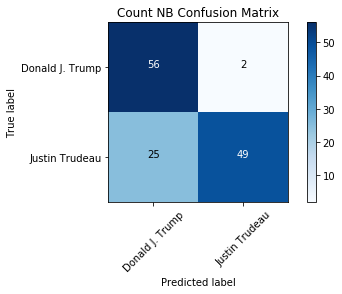

In [17]:
%matplotlib inline

from data.helper_functions import plot_confusion_matrix

# Plot the tfidf_nb_cm confusion matrix
plot_confusion_matrix(tfidf_nb_cm, classes=['Donald J. Trump', 'Justin Trudeau'], title="TF-IDF NB Confusion Matrix")

# Plot the count_nb_cm confusion matrix without overwriting the first plot 
plot_confusion_matrix(count_nb_cm, classes=['Donald J. Trump', 'Justin Trudeau'], title="Count NB Confusion Matrix", figure=1)

## Trying out another classifier: Linear SVC
<p>So the Bayesian model only has one prediction difference between the TF-IDF and count vectorizers -- fairly impressive! Interestingly, there is some confusion when the predicted label is Trump but the actual tweeter is Trudeau. If we were going to use this model, we would want to investigate what tokens are causing the confusion in order to improve the model. </p>
<p>Now that we've seen what the Bayesian model can do, how about trying a different approach? <a href="https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html">LinearSVC</a> is another popular choice for text classification. Let's see if using it with the TF-IDF vectors improves the accuracy of the classifier!</p>

LinearSVC Score:   0.841
Confusion matrix, without normalization


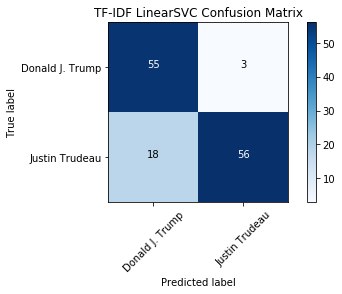

In [18]:
# Create a LinearSVC model
tfidf_svc = LinearSVC()

# Train model
tfidf_svc.fit(tfidf_train, y_train)

# Run predict on tfidf test data to get predictions
tfidf_svc_pred = tfidf_svc.predict(tfidf_test)

# Calculate accuracy using the metrics module
tfidf_svc_score = tfidf_svc.score(tfidf_test, y_test)

print("LinearSVC Score:   %0.3f" % tfidf_svc_score)

# Calculate the confusion matrices for the tfidf_svc model
svc_cm = metrics.confusion_matrix(y_test, tfidf_svc_pred, labels=['Donald J. Trump', 'Justin Trudeau'])

# Plot the confusion matrix using the plot_confusion_matrix function
plot_confusion_matrix(svc_cm, classes=['Donald J. Trump', 'Justin Trudeau'], title="TF-IDF LinearSVC Confusion Matrix")

## Introspecting our top model
The LinearSVC model is even better than the Multinomial Bayesian one. Via the confusion matrix we can see that, although there is still some confusion where Trudeau's tweets are classified as Trump's, the False Positive rate is better than the previous model. So, we have a performant model. 

We might be able to continue tweaking and improving all of the previous models by parameter optimization or applying some better preprocessing of the tweets.

Now let's see what the model has learned. Using the LinearSVC Classifier with two classes (Trump and Trudeau) we can sort the features (tokens), by their weight and see the most important tokens for both Trump and Trudeau.
    
What are the most Trump-like or Trudeau-like words? Did the model learn something useful to distinguish between these two men?

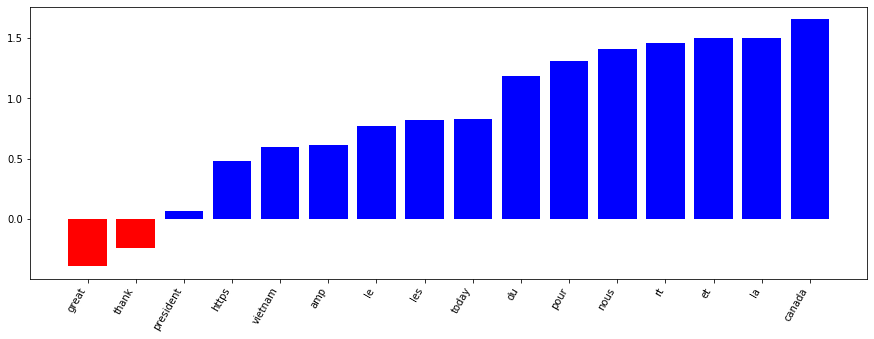

[(-0.39597215018997367, 'great'),
 (-0.24645038190736127, 'thank'),
 (0.06257415519330874, 'president'),
 (0.48211728590926733, 'https'),
 (0.5960539278162452, 'vietnam'),
 (0.6155600413865155, 'amp'),
 (0.7725801006980898, 'le'),
 (0.8213824945118332, 'les'),
 (0.8286559533310098, 'today'),
 (1.1869078634868757, 'du'),
 (1.3143466426589534, 'pour'),
 (1.4122543843478754, 'nous'),
 (1.4612767389235006, 'rt'),
 (1.49917587956083, 'et'),
 (1.5056442320488004, 'la'),
 (1.65679911556019, 'canada')]


In [19]:
from data.helper_functions import plot_and_return_top_features

# Import pprint from pprint
from pprint import pprint

# Get the top features using the plot_and_return_top_features function and top model and tfidf vectorizer
top_features = plot_and_return_top_features(tfidf_svc, tfidf_vectorizer)

# pprint the top features
pprint(top_features)

## Trump or Trudeau tweet?

It seems like the model learned that Trudeau tweets in French, since many of the words in the top deatures list are French. Those are mostly the common words, or, "stop words". We could remove both English and French stop words from the tweets as a preprocessing step, but that might decrease the accuracy of the model because Trudeau is the only French-speaker in the group. If we had a dataset with more than one French speaker, this would be a useful preprocessing step.

<p>Future work on this dataset could involve:</p>
<ul>
<li>Add extra preprocessing (such as removing URLs or French stop words) and see the effects</li>
<li>Use GridSearchCV to improve both Bayesian and LinearSVC models by finding the optimal parameters</li>
<li>Introspect the Bayesian model to determine what words are more Trump- or Trudeau- like</li>
<li>Add more recent tweets to the dataset using tweepy and retrain</li>
</ul>

Let's write our own tweet using the knowledge gained to trick the model! We'll use the plot above to make some inferences about what words will classify the text as Trump or Trudeau. 


In [20]:
# Write two tweets as strings, one which you want to classify as Trump and one as Trudeau
trump_tweet = "I thank you for being a great patriot!"
trudeau_tweet = "Le moi je les"

# Vectorize each tweet using the TF-IDF vectorizer's transform method
trump_tweet_vectorized = tfidf_vectorizer.transform([trump_tweet])
trudeau_tweet_vectorized = tfidf_vectorizer.transform([trudeau_tweet])

# Call the predict method on vectorized tweets
trump_tweet_pred = tfidf_svc.predict(trump_tweet_vectorized)
trudeau_tweet_pred = tfidf_svc.predict(trudeau_tweet_vectorized)

print("Predicted Trump tweet", trump_tweet_pred)
print("Predicted Trudeau tweet", trudeau_tweet_pred)

Predicted Trump tweet ['Donald J. Trump']
Predicted Trudeau tweet ['Justin Trudeau']
